# 1. Dataset
The dataset we will be using is the Poetry Foundation Poems Dataset, containing around 14 thousand samples. You can find it on Kaggle [here](https://www.kaggle.com/datasets/tgdivy/poetry-foundation-poems)

## 1.1 Kaggle
First we need the kaggle cli to download the dataset.

Note: You will need a Kaggle.json file.

In [1]:
from google.colab.files import upload

In [2]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

Installing kaggle
Upload kaggle.json


Saving kaggle.json to kaggle.json
Setting kaggle up...
Done!


## 1.2 Downloading dataset

In [3]:
import os

In [4]:
DATA_FILENAME = "data.csv"

In [5]:
if not os.path.exists(DATA_FILENAME):
  !kaggle datasets download -d tgdivy/poetry-foundation-poems
  print("\nUnzipping dataset...")
  !unzip -q poetry-foundation-poems.zip
  os.rename("PoetryFoundationData.csv", DATA_FILENAME)
  os.remove("poetry-foundation-poems.zip")
  print("Dataset is ready to be cleaned!")
else:
  print("Dataset already exists")

  0% 0.00/8.88M [00:00<?, ?B/s]
100% 8.88M/8.88M [00:00<00:00, 132MB/s]

Unzipping dataset...
Dataset is ready to be cleaned!


## 1.3 Getting inputs
Since this is an unsupervised task we will not have labels

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(DATA_FILENAME)
df.head()

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN
4,4,\r\r\n Umbrella\r\r\n ...,\r\r\nWhen I push your button\r\r\nyou fly off...,Connie Wanek,NaN


In [8]:
inputs = df["Poem"].values

## 1.4 Train and valid split

In [9]:
import numpy as np
from tqdm.notebook import tqdm

In [10]:
train_portion = int(0.8 * len(inputs)) # Amount of the total dataset which is the training set

In [28]:
X_train, X_test = [], []

for i, sample in enumerate(tqdm(inputs)):
  if i < train_portion:
    X_train.append(sample)
  else:
    X_test.append(sample)

print("Completed!")

  0%|          | 0/13854 [00:00<?, ?it/s]

Completed!


In [29]:
len(X_train), len(X_test)

(11083, 2771)

## 1.5 Tokenizing data
Here is how we will tokenize:

* Remove stopwords i.e. is, are, am

* Get 1000 most common words in our reviews

* Assign all those 1000 words a numerical value based on popularity

* Create a new list in which the items are the reviews from X_train but the review is made from the 1000 most common words.

In [30]:
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [31]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
class Tokenizer():
  def preprocess_word(self, word):
    # Remove any characters which are not letters
    word = re.sub(r'[^a-zA-Z]+', '', word)
    return word
  
  def _create_word_list(self, array):
    word_list = []

    stop_words = set(stopwords.words("english"))
    print("Getting and preprocessing words...")
    for string in tqdm(array):
      for word in string.lower().split():
        word = self.preprocess_word(word)
        word_list.append(word)
    
    return word_list
  
  def tokenize(self, X_train, X_test, amount_common_words=5000):
    word_list = self._create_word_list(X_train)
    corpus = Counter(word_list) # Get common words
    corpus = sorted(corpus, key=corpus.get, reverse=True)[:amount_common_words] # Sort them based on commonnesss and get x (5000) amount of them
    corpus_num_dict = {w: i+1 for i, w in enumerate(corpus)} # Give numerical value to those common words

    X_train_tok, X_test_tok = [], []

    print(f"\nSetting words in arrays...")
    for poem in tqdm(X_train):
      # appends the numerical value of every word in poem only if it is in the 5000 most common words (corpus_num_dict)
      X_train_tok.append([corpus_num_dict[self.preprocess_word(word)] for word in poem.lower().split() 
                                if self.preprocess_word(word) in corpus_num_dict.keys()])

    for poem in tqdm(X_test):
      X_test_tok.append([corpus_num_dict[self.preprocess_word(word)] for word in poem.lower().split() 
                                if self.preprocess_word(word) in corpus_num_dict.keys()])

    print("Tokenized!")

    return np.array(X_train_tok), np.array(X_test_tok), corpus_num_dict

In [36]:
tokenizer = Tokenizer()

In [37]:
X_train, X_test, vocab = tokenizer.tokenize(X_train, X_test)

Getting and preprocessing words...


  0%|          | 0/11083 [00:00<?, ?it/s]


Setting words in arrays...


  0%|          | 0/11083 [00:00<?, ?it/s]

  0%|          | 0/2771 [00:00<?, ?it/s]

Tokenized!


<ipython-input-35-dc73ba86a915>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_train_tok), np.array(X_test_tok), corpus_num_dict


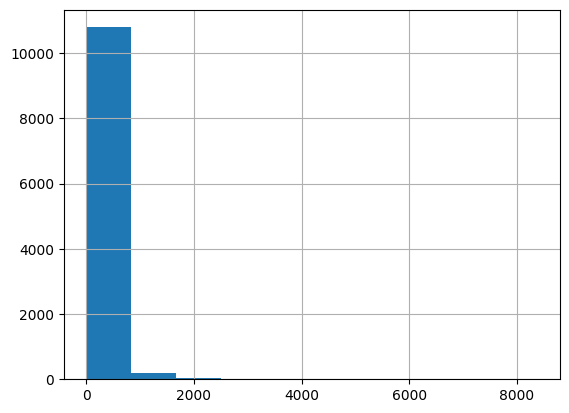

count    11083.000000
mean       214.977984
std        355.389100
min          0.000000
25%         83.000000
50%        134.000000
75%        230.000000
max       8374.000000
dtype: float64

In [38]:
len_poems = [len(poem) for poem in X_train]
pd.Series(len_poems).hist()
plt.show()
print("")
pd.Series(len_poems).describe()

## 1.6 Pad data

In [51]:
pad_length = 300

In [47]:
def pad_arr(array, length):
  features = np.zeros((len(X_train), length))
  for row, item in enumerate(array):
    if len(item) > 0:
      features[row, -len(item):] = np.array(item)[:length]
  return features

In [52]:
X_train_pad = pad_arr(X_train, pad_length)
X_test_pad = pad_arr(X_train, pad_length)

## 1.7 Load data

In [60]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [56]:
batch_size = 64

In [61]:
train_ds = TensorDataset(torch.from_numpy(X_train_pad))
test_ds = TensorDataset(torch.from_numpy(X_test_pad))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)